In [1]:
from math import pi
import matplotlib.pyplot as plt
# from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

In [2]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)

# define my own embedding layer
# def myembedding(x,wires):
#     # qml.RY(np.arcsin(x), wires=wires[0])
#     # qml.RY(2*pi*x, wires=wires[1])

def myembedding(x,wires):
    qml.RY(x, wires=wires[1])

def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubits
    qml.RY(theta[0],wires=0)
    qml.RY(theta[1],wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def quantum_net(theta,x):
    
    # encode data
    myembedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))

In [3]:

# print(theta.shape)
# # print(theta)
# print(qml.draw(quantum_net)(theta,0))



# add the classical layer
def classical_quantum_net(theta,w,x):
    r=quantum_net(theta,x)
    return w[0]+w[1]*r+w[2]*r**2
    # return w[0]+w[1]*r



In [4]:
import numpy as np
from scipy.optimize import minimize


def f(theta,w, t):
    r=quantum_net(theta,t)
    return w[0]+w[1]*r+w[2]*r**2


# Differential equation parameters
ws = 376.9911
# Boundary condition 
coefii = 10

# del_0 = 0  #del
# omega_0 = 0     #w
# del_0_v = -1/coefii
# omega_0_v = 383.9911/coefii
del_0_v = 0.06849121354238719
omega_0_v = 37.70827244775329

K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii
def DE(f,f_prime,f_double_prime,t):
    delta = f
    delta_prime = f_prime
    omega = delta_prime+ws
    omega_prime = f_double_prime
    return (delta_prime+ws-omega)+omega_prime-K1+K2*np.sin(coefii*delta)+K3*(-ws+omega)*coefii
    

n_grid = 20
range_min = 4
range_max = 4.5
t_data = np.linspace(range_min, range_max, n_grid)
dt = t_data[1]-t_data[0]
# print(dt)
print(t_data)
# del_target_values = [-0.1, -0.08568864375010266, -0.07135199292327042, -0.05703216366155178, -0.04277533332758968, -0.028630566403092566, -0.014648393492369936, -0.0008786099410683636, 0.012629993562057113, 0.025830965225360485, 0.03868190003112095, 0.05114514907683676, 0.06318818053413534, 0.07478349631699908, 0.08590929364185632, 0.09655108128205876, 0.10669910851327256, 0.11634802541217151, 0.12549688285643618, 0.13414913252475494, 0.1423124546002818, 0.14999727816970396, 0.1572170147933966, 0.16398646160587024, 0.17032150117763253, 0.17623910151518826, 0.18175731606103976, 0.18689528211221512, 0.19167252338163385, 0.1961073022258, 0.2002172705183872, 0.2040196495808423, 0.20753123018238517, 0.21076837254000894, 0.21374700631847987, 0.2164826306303374, 0.21899031403589397, 0.22128469454323552, 0.2233792634241711, 0.22528520015009165, 0.22701309424038968, 0.22857304585789437, 0.22997466468065175, 0.2312270699019247, 0.23233889023019288, 0.23331826388915283, 0.23417283861771784, 0.2349097716700181, 0.2355355471757422, 0.23605508170803655]
# omega_target_values = [38.39911, 38.40131255162024, 38.401559501400065, 38.399627615014815, 38.39535272010845, 38.38863569037213, 38.37944575798523, 38.36781828175373, 38.35385457506316, 38.33771250498817, 38.31960064799821, 38.29975795463622, 38.27844654658136, 38.25594953663366, 38.232548774138536, 38.20852344187769, 38.184133101993716, 38.15961422638989, 38.135180196730154, 38.11102130443908, 38.0873045267779, 38.0641648590319, 38.04170495996719, 38.020008128295665, 37.999139183467754, 37.979144465672405, 37.96005183583712, 37.94187079269068, 37.92460193204962, 37.90823330461032, 37.892744190413474, 37.87811073974539, 37.864305973137945, 37.851299781368624, 37.83905892546051, 37.82754703668229, 37.816724616548235, 37.80654903681822, 37.7969789305147, 37.78797953688034, 37.779515522995986, 37.77155243468513, 37.76405670589686, 37.75699565870589, 37.75033750331248, 37.744051338042496, 37.73810714934741, 37.73247581180426, 37.72712975291509, 37.7220465421391]


def callbackF(parameters):
    # global current_loss

    print("Current loss:", cost(parameters)) 


def cost(params):
    global theta
    global w
    # Reshape the flattened theta back to its original shape
    theta_shape = theta.shape
    w_shape = w.shape
    w, theta_flat = params[:3], params[3:]
    theta = theta_flat.reshape(theta_shape)


    u = np.zeros(n_grid + 2)
    u[0] = f(theta,w, range_min - dt)
    u[1] = del_0_v
    for i in range(1, n_grid):
        u[i + 1] = f(theta,w, t_data[i])
    u[n_grid + 1]=f(theta,w, range_max + dt)
  
    u_prime = (u[2:] - u[:-2])/(2*dt)
    omega_0 = u_prime[0]+ws
    u_double_prime = (u_prime[2:] - u_prime[:-2])/(2*dt)
    loss_i = np.sum((DE(f=u[2:-2],f_prime=u_prime[1:-1],f_double_prime=u_double_prime,t=t_data[1:-1]))**2)
    
    eta = 5
    # del0_pred = f(a, b, c, d, 0)
    # omega0_pred = f_prime(a, b, c, d, 0) + ws
    # loss_b = eta * (del_0_v - del0_pred) ** 2 * len(t_data)
    loss_b = 0
    loss_b += eta * (omega_0_v - omega_0) ** 2 * len(t_data)

    # loss = 10*loss_i+8*loss_b
    loss = loss_i+loss_b
    # loss = loss_i
    # print("Current loss:", loss) 
    return loss



[4.         4.02631579 4.05263158 4.07894737 4.10526316 4.13157895
 4.15789474 4.18421053 4.21052632 4.23684211 4.26315789 4.28947368
 4.31578947 4.34210526 4.36842105 4.39473684 4.42105263 4.44736842
 4.47368421 4.5       ]


In [5]:

# opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

# num_layers=4
# theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits),requires_grad=True)
# w=np.zeros(3,requires_grad=True)


# epochs=100
# for e in range(1,epochs+1):
    
#     (theta,w,_),_cost=opt.step_and_cost(cost,theta,w,t_data)
#     if e==1 or e%10==0:
#         print(f'Epoch: {e} | Cost: {_cost} | w: {w} | theta: {theta}')

In [6]:
num_layers=4

theta = np.random.uniform(0, 2 * np.pi, size=(num_layers, num_qubits))
w = np.zeros(3)

initial_params = np.concatenate([w, theta.flatten()])  # Flatten theta to a 1D array

result = minimize(cost, initial_params, callback=callbackF, method='BFGS', options={'gtol': 1E-2})
# Extract the optimized parameters
w, theta_flat = result.x[:3], result.x[3:]
theta = theta_flat.reshape(theta.shape)

Current loss: 0.44188140400599485
Current loss: 0.2188884217885707
Current loss: 0.21235124117499043
Current loss: 0.15066684894211288
Current loss: 0.13445406486059364
Current loss: 0.11829333217204256
Current loss: 0.10261669673768213
Current loss: 0.08638897673847981
Current loss: 0.07448455805679373
Current loss: 0.06859801148092917
Current loss: 0.061389629567587645
Current loss: 0.05449081611514815
Current loss: 0.04813581592345667
Current loss: 0.043416184867645896
Current loss: 0.03692858328060425
Current loss: 0.03113592732065762
Current loss: 0.02986976080755431
Current loss: 0.02813255774342929
Current loss: 0.026593050711613542
Current loss: 0.025664359786187595
Current loss: 0.02552907207335085
Current loss: 0.025277960078284974
Current loss: 0.024856411910765135
Current loss: 0.024196263793678577
Current loss: 0.023217376201913588
Current loss: 0.02194743953780393
Current loss: 0.020427973273937878
Current loss: 0.019425098879206185
Current loss: 0.017842202840853427
Curr

In [7]:
print(w)
print(theta)

[ -5.16472357 -12.86380215  -7.90464287]
[[4.80281742 0.12305532]
 [3.67838896 6.4861166 ]
 [3.43265643 2.86827679]
 [3.59963873 3.41434627]]


In [8]:
# num_layers=4
# # theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits),requires_grad=True)
# theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits))
# # w=np.zeros(3,requires_grad=True)
# w=np.zeros(3)


# initial_params = [w,theta]
# # initial_params = [4, 4, 4,4]
# # initial_params = [10, 20, 8,70]
# # initial_params = [1.5703050481447, 6.664583545312459, 8.490607793546264,-1.0593486531798044]
# # initial_params = [0.17749722218115743, -0.6981313539613472, 0.8622182932697816,-0.1070692270857497]

# # result = minimize(loss, initial_params, method='Nelder-Mead')
# result = minimize(cost, initial_params, callback=callbackF, method='BFGS', options={'gtol': 1E-2})

# theta,w = result.x

In [9]:
del_target_values =[0.06746196231769255, 0.06784104219213707, 0.06811717131839819, 0.06829311391334661, 0.06837205601413529, 0.06835760547819951, 0.06825379198325679, 0.06806506702730693, 0.06779630392863203, 0.06745279782579647, 0.06704026567764686, 0.06656484626331217, 0.06603187200750953, 0.06544458228251931, 0.06480889195617669, 0.06413073433919532, 0.06341589443304417, 0.06267000892994755, 0.06189856621288503, 0.06110690635559149]
omega_target_values = [37.71542570504385, 37.711456418454304, 37.7075965228758, 37.70386274051706, 37.70027003500497, 37.69683161138449, 37.69355891611874, 37.69046163708894, 37.687547703594426, 37.68482328635267, 37.68229279749925, 37.67995889058789, 37.67782370038612, 37.67589225954756, 37.67416769544909, 37.67265189054115, 37.671345597528294, 37.670248439369296, 37.669358909277065, 37.66867437071868]



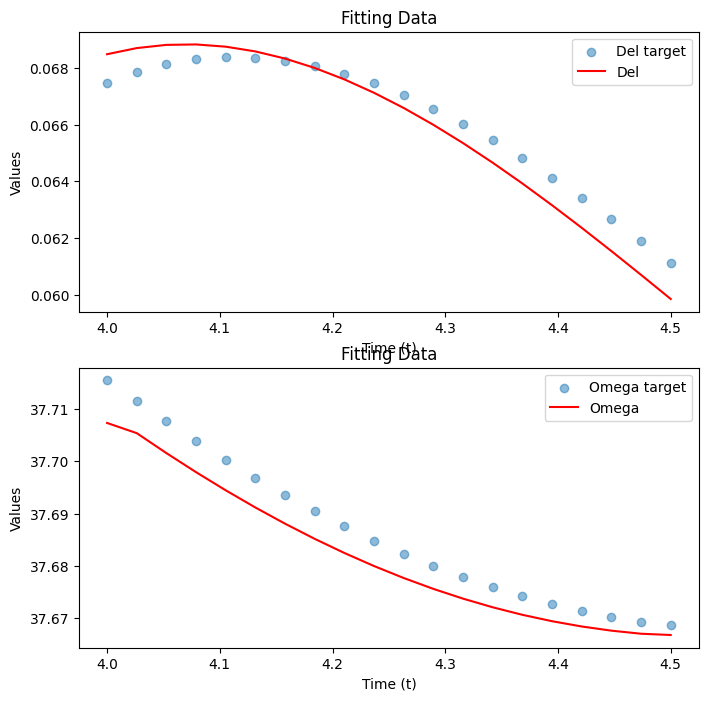

20
20
0.05985503591105523
37.666800835173966
[0.06847785 0.06869356 0.06880675 0.06882178 0.06874322 0.06857581
 0.06832448 0.06799428 0.06759042 0.06711822 0.06658309 0.06599053
 0.06534611 0.06465543 0.06392413 0.06315784 0.06236221 0.06154283
 0.06070528 0.05985504]
[37.70730695 37.70535905 37.70154617 37.69790291 37.69443658 37.69115387
 37.68806083 37.68516289 37.68246482 37.67997072 37.67768402 37.67560746
 37.67374311 37.67209233 37.67065581 37.66943354 37.66842481 37.66762826
 37.66704182 37.66680084]


In [10]:
import matplotlib.pyplot as plt

# Plot the target values and the fitted curve
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.scatter(t_data, del_target_values, label='Del target', alpha=0.5)
delta_pred = f(theta,w,t_data)
plt.plot(t_data, delta_pred, 'r', label='Del')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('Fitting Data')


# Plot the target values and the fitted curve
# plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 2)
plt.scatter(t_data, omega_target_values, label='Omega target', alpha=0.5)

del_prime = np.gradient(delta_pred, t_data)
omega_pred = del_prime+ws

plt.plot(t_data, omega_pred, 'r', label='Omega')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('Fitting Data')
plt.show()

# plt.show()
print(len(delta_pred))
print(len(omega_pred))
print(delta_pred[-1])
print(omega_pred[-1])

print(delta_pred)
print(omega_pred)